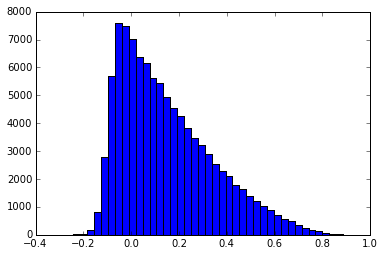

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

N = 100000

delta = stats.beta.rvs(99, 11, size = N) - stats.beta.rvs(3, 1, size = N)
delta.sort()
plt.hist(delta, bins = 40)
plt.show()

In [94]:
delta[N * 25 / 1000], delta[N * 975 / 1000]

(-0.10676694587338864, 0.60912617440149008)

In [119]:
p = 0.0
size = 1000
rng = np.linspace(0, 1, size + 1)
pjs = stats.beta.logpdf(rng, 3, 1)

for i, pi in enumerate(stats.beta.logpdf(rng, 99, 11)):
    for j, pj in enumerate(pjs):
        if i > j:
            p += np.exp(pi + pj)
            
p /= size ** 2
p

0.7299618399613742

In [54]:
import numpy as np
import math
import cancer
import sklearn.preprocessing

In [2]:
X_train, y_train = cancer.get_train()
X_train = sklearn.preprocessing.scale(X_train)
X_test, y_test = cancer.get_test()
X_test = sklearn.preprocessing.scale(X_test)

In [6]:
def soft_threshold(a, delta):
    return np.array([np.sign(x) * max(np.abs(x) - delta, 0) for x in a])

In [52]:
def fit(X, y, delta):
    N, D = X.shape
    cs = np.unique(y)
    C = len(cs)
    sse = np.zeros(D)
    mus = []
    prior = []
    xbar = np.mean(X, axis = 0)

    for c in cs:
        i = y == c
        X_c = X[i]
        prior.append(np.mean(i))
        mu_c = np.mean(X_c, axis = 0)
        mus.append(mu_c)
        sse += np.sum((X_c - mu_c) ** 2, axis = 0)
        
    sigma2 = sse / (1.0 * N - C)
    sigma = np.sqrt(sigma2)
    s0 = np.median(sigma)
    
    for i, c in enumerate(cs):
        m = math.sqrt(1.0 / sum(y == c) - 1.0 / N)
        d = (mus[i] - xbar) / (m * (sigma + s0))
        d = soft_threshold(d, delta)
        mus[i] = xbar + m * (sigma + s0) * d
        
    return cs, np.log(prior), mus, sigma2
        
def predict(model, X):
    cs, log_prior, mus, sigma2 = model
    N, D = X.shape
    C = len(cs)
    loglik = np.empty((N, C))
    
    for i in range(C):
        Z = 0.5 * (X - mus[i]) ** 2 / sigma2
        loglik[:, i] = log_prior[i] - np.sum([Z[:, j] for j in range(D)], axis = 0)
    
    return cs[np.argmax(loglik, axis = 1)]

In [53]:
model = fit(X_train, y_train, 3)
print np.sum(predict(model, X_test) != y_test), 'errors out of', len(y_test)

19 errors out of 54
